In [1]:
from typing import Optional
import math
from collections import OrderedDict

import matplotlib
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from einops import rearrange, einsum

torch.manual_seed(1234)

### Sinusoidal Positional Encodings

This is used to inject some positional information into the embeddings of the token sequence. Since we compute the next token for every single token in parallel, we want some info about the position of a token within a sequence to be represented as well.
1. Unique encoding for each position (across all sequences)
2. Generalize to longer sequence than seen in training
3. Generated deterministically (so the model can learn it)
4. Linear relation between 2 encoded positions (again to help the model learn relationships)


Given a position $pos$ output a vector $d_{model}$ such that for each location $i$ in the vector the output is $$PE_{pos,2i} = \sin(pos/10000^{2i/d_{model}})$$ $$PE_{pos,2i+1} = \cos(pos/10000^{2i/d_{model}})$$
for even and odd indices respectively

we refactor as $$PE_{pos,2i} = \sin(pos.w)$$ $$PE_{pos,2i+1} = \cos(pos.w)$$ where $w=1/(10000^{2i/d_{model}}) for 0 <= 2i <= d_{model}$

![Sinusoidal PE visualization](fleetwood_sinusoidal.png "https://fleetwood.dev/posts/you-could-have-designed-SOTA-positional-encoding")
Look at the functions. For a dimension $i$ the $sin/cos$ function's wave starts out extremely quickly changing values for small $i$, and slows down a lot up to a wavelength of $10000*2\pi$.

#### Derivation to use tensor ops
$$\frac{1}{10000^{k/d_{model}}} = 10000^{-k/d_{model}} = \exp(\log(10000^{-k/d_{model}}))$$
$$ = \exp(-k/d_{model} * \log(10000))$$
this is basically
$$torch.exp(k * (-\frac{1}{d_{model}}) * \log(10000))$$

In [2]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000) -> None:
        """Construct the entire positional encoding."""
        super().__init__()
        w = torch.exp(torch.arange(0, d_model, 2) * ((-1/d_model) * math.log(10000)))
        PE = torch.zeros([max_len, d_model])
        positions = torch.arange(0, max_len)
        # We have 2 vectors
        assert (positions.shape == (max_len,))
        assert (w.shape == (d_model // 2,))
        # If we reshape positions into a row of columns [[0], [1], [2], ...] then 
        # positions @ w -> gives us a matrix of shape [max_len, d_model/2 ]
        positions = rearrange(positions, "(len column) -> len column", column=1)
        PE[:, 0::2] = torch.sin(positions * w)
        PE[:, 1::2] = torch.cos(positions * w)
        self.register_buffer("PE", PE) # this is not to be a learnable parameter
        # However we do want it to be moved along with model.to(device) 
    
    def forward(self, x):
        _, L, D = x.shape
        x += self.PE[:L, :D]
        return x

Just a reference implementation with for-loops to demonstrate speedup of torch ops.

In [3]:
# output pe -> [d_model]
def sinusoidal_position_encoding(pos: int, d_model: int = 512) -> torch.Tensor:
    # w = 1/10000**(2i/d_model)
    w = torch.tensor([1/(10_000**(k/d_model)) for k in range(0, d_model, 2)])
    x_indices = pos * w 
    PE_even = torch.sin(x_indices)
    PE_odd = torch.cos(x_indices)
    PE_even = rearrange(PE_even, "(new_dim l) -> l new_dim", new_dim=1)
    PE_odd = rearrange(PE_odd, "(new_dim l) -> l new_dim", new_dim=1)
    interleaved_result = rearrange([PE_even, PE_odd], "function d_model element -> (d_model element function)")
    assert (interleaved_result.shape == (d_model,))
    return interleaved_result

def generate_position_encoding(max_len: int = 5000, d_model: int = 512) -> torch.Tensor:
    all_positions_encoding = torch.zeros([max_len, d_model], dtype=torch.float32)
    for position in range(max_len):
        all_positions_encoding[position, :] += sinusoidal_position_encoding(position, d_model)
    return all_positions_encoding

#### Note below the speed differential of the vectorized pytorch ops. Eye the units 👀

In [5]:
%%timeit
generate_position_encoding()

239 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
SinusoidalPositionalEncoding(512)

391 μs ± 19.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
def test_sinusoidal_positional_encoding_class():
    max_len = 500
    d_model = 512
    pe_class = SinusoidalPositionalEncoding(d_model=d_model, max_len=max_len)

    
    print(pe_class(torch.zeros([1, max_len, d_model])) == generate_position_encoding(max_len=max_len, d_model=d_model).unsqueeze(0))
    assert(torch.allclose(pe_class(torch.zeros([1, max_len, d_model])), generate_position_encoding(max_len=max_len, d_model=d_model).unsqueeze(0)))

test_sinusoidal_positional_encoding_class()

tensor([[[ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True, False,  True],
         ...,
         [ True,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True, False,  True]]])


AssertionError: 

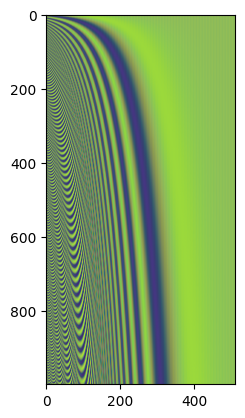

In [8]:
import matplotlib.pyplot


matplotlib.pyplot.imshow((SinusoidalPositionalEncoding(d_model=512, max_len=1000).PE).numpy())

matplotlib.pyplot.show()

#### Function that calculates attention (single-headed for now).

#### A Decoder-Only Transformer Language Model
Implemented with single headed attention

In [9]:
"""
Dimension key:
L: sequence length
D: model dimension (d_model)
V: vocabulary size
F: feed-forward subnetwork's hidden size
K: size of each attention key or value (d_k,d_v,d_kv)
"""

"\nDimension key:\nL: sequence length\nD: model dimension (d_model)\nV: vocabulary size\nF: feed-forward subnetwork's hidden size\nK: size of each attention key or value (d_k,d_v,d_kv)\n"

In [10]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vector_size: int, vocab_size: int):
        super().__init__()
        self.d_model = vector_size
        self.scaling_factor = math.sqrt(self.d_model) # a detail in the paper
        self.lut = nn.Embedding(vocab_size, vector_size)
    
    def forward(self, input_indices: torch.Tensor):
        return self.lut(input_indices) * self.scaling_factor

    def get_weights(self):
        return self.lut.weight

In [11]:
class SelfAttention(nn.Module):
    def __init__(self, d_model: int, mask: bool):
        super().__init__()
        self.scale_factor = math.sqrt(d_model)
        self.mask = mask
    
    def forward(self, Q_BLK, K_BLK, V_BLK) -> torch.Tensor:
        assert (Q_BLK.shape == K_BLK.shape)

        K_BKL = rearrange(K_BLK, "B L K -> B K L")

        qk_BLL = einsum(Q_BLK, K_BKL, "B L_Q K, B K L_K -> B L_Q L_K")
        # TODO: Should this be before or after the mask
        scaled_qk_BLL = qk_BLL
        scaled_qk_BLL = qk_BLL / math.sqrt(self.scale_factor)
        # since we want to average the attended keys between the dimension d_k
        if self.mask:
            tril_qk = torch.tril(scaled_qk_BLL)
            scaled_qk_BLL = torch.where(tril_qk == 0, float("-inf"), scaled_qk_BLL)

        weighted_keys_BLL = torch.softmax(scaled_qk_BLL, dim=-1)
        attention_output_BLV = einsum(weighted_keys_BLL, V_BLK, "B L_Q L , B L D_V -> B L_Q D_V") 
        return attention_output_BLV

In [12]:
class FeedForward(nn.Module):
    def __init__(self, D: int, H: int = 2048):
        super().__init__()
        self.layers = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(D, H)),
            ("relu1", nn.ReLU()),
            ("linear2", nn.Linear(H, D)),
        ]))
    
    def forward(self, x):
        return self.layers.forward(x)



class Decoder(nn.Module):
    def __init__(self, d_model: int, d_k: int, d_v: int, P_drop: int, n_heads = 8):
        super().__init__()
        # attention function
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.P_drop = P_drop
        self.W_query_DK = nn.Parameter(torch.randn([self.d_model, self.d_k]), requires_grad=True)
        self.W_key_DK = nn.Parameter(torch.randn([self.d_model, self.d_k]), requires_grad=True)
        self.W_value_DK = nn.Parameter(torch.randn([self.d_model, self.d_v]), requires_grad=True)
        nn.init.kaiming_uniform_(self.W_query_DK)
        nn.init.kaiming_uniform_(self.W_key_DK)
        nn.init.kaiming_uniform_(self.W_value_DK)

        mask = self.training 
        self.attn = SelfAttention(d_model=True, mask=mask)

        # normalize over the last dimension in shape [N, d_v], so each layer
        self.dropout1 = nn.Dropout(p=self.P_drop)
        self.layernorm1 = nn.LayerNorm(self.d_v)
        self.feedforward = FeedForward(D=self.d_model)
        self.dropout2 = nn.Dropout(p=self.P_drop)
        self.layernorm2 = nn.LayerNorm(self.d_model)
    
    def forward(self, input_BLD: torch.Tensor) -> torch.Tensor:
        assert(input_BLD.dim() == 3 and input_BLD.shape[-1] == self.d_model)
        input_token_length = input_BLD.shape[1]

        Query_BLK = torch.matmul(input_BLD, self.W_query_DK)
        Key_BLK = torch.matmul(input_BLD, self.W_key_DK)
        Value_BLK = torch.matmul(input_BLD, self.W_value_DK)

        # attn_values_BLV = self.scaled_dot_prd_attention(Query_BLK, Key_BLK, Value_BLK, visualize_attn=False)
        attn_values_BLV = self.attn(Query_BLK, Key_BLK, Value_BLK)
        built_in_attn = F.scaled_dot_product_attention(Query_BLK.unsqueeze(1), Key_BLK.unsqueeze(1), Value_BLK.unsqueeze(1), is_causal=True)
        attn_values_BLV = rearrange(built_in_attn, "B H L V -> (B H) L V")

        assert(torch.allclose(attn_values_BLV.unsqueeze(1), built_in_attn))

        reg_attn_values_BLV = self.dropout1(attn_values_BLV)
        normalized_attn_values_BLV = self.layernorm1(reg_attn_values_BLV + input_BLD)
        assert(normalized_attn_values_BLV.shape == attn_values_BLV.shape)
        assert(normalized_attn_values_BLV.dim() == 3 and normalized_attn_values_BLV.shape[-1] == self.d_model)

        ffn_BLD = self.feedforward(normalized_attn_values_BLV)
        reg_ffn_BLD = self.dropout1(ffn_BLD)

        normalized_ffn_BLD = self.layernorm2(reg_ffn_BLD + normalized_attn_values_BLV)
        return normalized_ffn_BLD
    
    # def scaled_dot_prd_attention(self, Query_BLK, Key_BLK, Value_BLK, mask: bool = True, visualize_attn: bool = False) -> torch.Tensor:
    #     assert (Query_BLK.shape == Key_BLK.shape)

    #     Key_BKL = rearrange(Key_BLK, "B L K -> B K L")

    #     qk_BLL = einsum(Query_BLK, Key_BKL, "B S_Q K, B K S_K -> B S_Q S_K")
    #     scaled_qk_BLL = qk_BLL / math.sqrt(self.d_model)
    #     # since we want to average the attended keys between the dimension d_k
    #     if mask:
    #         tril_qk = torch.tril(scaled_qk_BLL)
    #         scaled_qk_BLL = torch.where(tril_qk == 0, float("-inf"), scaled_qk_BLL)
    #     if visualize_attn:
    #         matplotlib.pyplot.matshow(scaled_qk_BLL[0].cpu().detach().numpy())

    #     weighted_keys_BLL = torch.softmax(scaled_qk_BLL, dim=-1)
    #     attention_output_BLV = einsum(weighted_keys_BLL, Value_BLK, "B S_Q L , B L D_V -> B S_Q D_V") 
    #     return attention_output_BLV



## Test Decoder

In [16]:
dec = Decoder(d_model=512, d_k=512, d_v=512, P_drop=0.1).to(device)

input = torch.randn([1, 16, 512], dtype=torch.float, device=device)
dec(input)

tensor([[[-0.9217,  0.5765, -0.6234,  ..., -1.6286, -1.0540, -1.2154],
         [-0.0761, -1.0499, -0.1227,  ...,  1.3930,  0.5311,  3.0073],
         [ 1.4379, -0.1705, -1.2402,  ..., -1.5188,  0.0329, -1.4420],
         ...,
         [ 0.0448, -0.4878, -1.1893,  ..., -1.0120, -0.1959, -0.2695],
         [ 0.6174,  1.0345,  0.0838,  ..., -0.5079, -1.3244, -0.5532],
         [ 0.9851,  1.0124,  1.1710,  ...,  0.2272,  0.0851, -0.3798]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [17]:
class Transformer(nn.Module):
    def __init__(self, d_model: int = 512, num_decoders: int = 6, maximum_sequence_length: int = 5000, P_drop: float = 0.1, vocabulary_size: int = 10000):

        super().__init__()
        assert (num_decoders >= 1)
        self.d_model = d_model
        self.d_k, self.d_v = d_model, d_model

        self.positional_encodings = SinusoidalPositionalEncoding(d_model=self.d_model)

        self.emb_dropout = nn.Dropout(p = P_drop)
        self.embed = EmbeddingLayer(vector_size=self.d_model, vocab_size=vocabulary_size)
        self.decoder_stack = nn.Sequential()
        for _ in range(num_decoders):
            self.decoder_stack.append(Decoder(d_model = self.d_model, d_k = self.d_k, d_v = self.d_v, P_drop = P_drop))

        self.linear = nn.Linear(self.d_model, vocabulary_size)
        self.linear.weight = self.embed.lut.weight
        self.logsoftmax = nn.LogSoftmax(dim=-1) # this is LogSoftmax so we can get the NLLLoss
    
    def forward(self, input_tokens_BL: torch.Tensor):
        assert(input_tokens_BL.dim() == 2 and input_tokens_BL.dtype == torch.int)
        B, L = input_tokens_BL.shape
        embed_tokens_BLD = self.embed(input_tokens_BL)
        assert(embed_tokens_BLD.dim() == 3 and embed_tokens_BLD.shape == torch.Size([B, L, self.d_model]))

        embed_tokens_BLD = self.positional_encodings(embed_tokens_BLD)

        decoder_output_BLD = self.decoder_stack(embed_tokens_BLD)

        assert(decoder_output_BLD.dim() == 3 and decoder_output_BLD.shape == torch.Size([B, L, self.d_model]))
        linear_output_BLV = self.linear(decoder_output_BLD)
        next_token_probabilities_BLV = self.logsoftmax(linear_output_BLV)

        # return linear_output_BLV
        return next_token_probabilities_BLV # this is of shape [seq_len, vocab_size] (each token has computed a probabilistic next token)
        """Now we map these back to the words based on the maximum token."""


In [15]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

def plot_grad_flow(named_parameters):
    avg_grads = []
    max_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and "bias" not in n:
            layers.append(n)
            avg_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    
    plt.bar(np.arange(len(max_grads)), max_grads, alpha = 0.1, lw=1, color="c")
    plt.bar(np.arange(len(avg_grads)), avg_grads, alpha = 0.1, lw=1, color="b")
    plt.hlines(0, 0, len(avg_grads)+1, lw=2, color="k")
    plt.xticks(range(0, len(avg_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(avg_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [14]:
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else device

In [18]:
%matplotlib inline
def test_transformer_runs():
    """With a dummy input lets just test if the components of the transformer fit together"""
    input_ints = torch.tensor([1, 2, 3, 4, 3, 6, 5, 7, 8], dtype=torch.int).to(device)
    batched_input = torch.stack((input_ints, input_ints))
    model = Transformer(d_model=8).to(device)
    print(model.forward(batched_input).shape)

test_transformer_runs()

torch.Size([2, 9, 10000])


Dataset sample generation

In [167]:
import random

def create_reversed_training_sample(vocab_size: int, max_sequence_length):
    """Generate a palindromic tensor of token indices.
    Returns: [A,Rev(A)]
    """
    random_sample_L = torch.randint(1, vocab_size-1, (max_sequence_length,), dtype=torch.int)
    return torch.cat((random_sample_L, torch.flip(random_sample_L, dims=(0,))))

def test_training_sample_generation():
    test_vocab_size=1000
    sample_length = 40
    gen_sample_L = create_reversed_training_sample(test_vocab_size, sample_length//2)
    assert gen_sample_L.shape == torch.Size([sample_length])
    orig_L, rev_L = torch.tensor_split(gen_sample_L, 2, dim=0)
    assert torch.allclose(orig_L, torch.flip(rev_L, dims=(0,)))

test_training_sample_generation()

In [19]:
def create_training_sample(vocab_size: int, max_sequence_length):
    """Generate a random tensor of token indices.
    """
    random_sample_L = torch.randint(1, vocab_size-1, (max_sequence_length,), dtype=torch.int)
    return random_sample_L

In [169]:

def shift_decoder_input_right(sample_BL: torch.Tensor) -> torch.Tensor:
    st_B = torch.zeros([sample_BL.shape[0], 1]).to(sample_BL.get_device(), dtype=torch.int32)
    return torch.cat([st_B, sample_BL], dim=1)

def pad_input_right(sample_BL: torch.Tensor) -> torch.Tensor:
    ed_B = torch.zeros([sample_BL.shape[0], 1]).to(sample_BL.get_device(), dtype=torch.int32)
    return torch.cat([sample_BL, ed_B], dim=1)

In [20]:
def train_loop(train_dataloader, model: torch.nn.Module, loss_fn, optimizer, device, epochs, train_dataset_len: int, scheduler: torch.optim.lr_scheduler, sequence_length: int,
                val_dataloader, test_dataset_len: int):
    record_train_loss = []
    record_train_accuracy = []
    record_val_loss = []
    record_val_accuracy = []
    for ep in range(epochs):
        train_loss, train_accuracy, test_loss, test_accuracy = 0, 0, 0, 0

        model.train()
        for idx, batch in enumerate(train_dataloader):
            batch_BL = batch.to(device)

            optimizer.zero_grad()
            # No shifting
            next_token_prob_BLV = model(batch_BL)
            flipped_BL = batch_BL.flip(dims=(1,))

            next_token_prob_BVL = rearrange(next_token_prob_BLV, "B L V -> B V L")
            # mask the first half

            loss = loss_fn(next_token_prob_BVL, flipped_BL.to(torch.long))
            loss.backward()
            optimizer.step()
            if idx == 200:
                print(f"Learning Rate: {scheduler.get_last_lr()}")
                plot_grad_flow(model.named_parameters())
                # return

            train_loss += loss.item()
            train_accuracy += (next_token_prob_BLV.argmax(-1) == flipped_BL).sum().item()
        scheduler.step()
        record_train_loss.append(train_loss/train_dataset_len)
        record_train_accuracy.append(train_accuracy / (train_dataset_len*sequence_length))
        
        model.eval()
        for idx, val_batch in enumerate(val_dataloader):
            # No shifting
            with torch.no_grad():
                val_batch_BL = val_batch.to(device)
                val_next_token_prob_BLV = model(val_batch_BL)
                val_flipped_BL = val_batch_BL.flip(dims=(1,))
                val_next_token_prob_BVL = rearrange(val_next_token_prob_BLV, "B L V -> B V L")

                val_loss = loss_fn(val_next_token_prob_BVL, val_flipped_BL.to(torch.long))

                test_loss += val_loss.item()
                test_accuracy+= (val_next_token_prob_BLV.argmax(-1) == val_flipped_BL).sum().item()
        record_val_loss.append(test_loss / test_dataset_len)
        record_val_accuracy.append(test_accuracy / (test_dataset_len * sequence_length))

        # if ep % 5 == 0:
        print(f"Epoch {ep}:")
        print(f"Loss = {record_train_loss[ep]} Accuracy = {record_train_accuracy[ep]}")
        print(f"Val Loss = {record_val_loss[ep]} Val Accuracy = {record_val_accuracy[ep]}")

        # if record_val_accuracy[ep] > 0.51:
        #     print("Early stopping")
        #     break



    
    return record_train_loss, record_train_accuracy, record_val_loss, record_val_accuracy



In [21]:
def test_loop(dataloader, model: torch.nn.Module, loss_fn, device):
    size = len(dataloader)
    print(f"Test set samples: {size}")
    model.eval()
    test_loss, correct = 0, 0
    total_tokens = 0
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            total_tokens += batch.numel()
            batch_BL = batch.to(device)
            # No shifting
            next_token_prob_BLV = model(batch_BL)
            flipped_BL = batch_BL.flip(dims=(1,))

            next_token_prob_BVL = next_token_prob_BLV.transpose(1, 2)

            test_loss += loss_fn(next_token_prob_BVL, flipped_BL.to(torch.long)).item()
            correct += (next_token_prob_BLV.argmax(dim=-1) == flipped_BL).sum().item()
    
    test_loss /= total_tokens
    correct /= total_tokens
    print(f"Test error: Accuracy: {100*correct}, Avg loss: {test_loss}\n")

### Train loop

In [ ]:
vocab_size = 16
max_sequence_length = 8
dataset_size = 10_000
batch_size = 32
dataset = [create_training_sample(vocab_size, max_sequence_length) for _ in range(int(dataset_size))]
# dataset = [torch.tensor([2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int) for _ in range(int(dataset_size))]
train_dataset = dataset[:int(dataset_size * .7)]
val_dataset = dataset[int(dataset_size * .7):]
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [24]:
model = Transformer(num_decoders=4, d_model=64, maximum_sequence_length=max_sequence_length, vocabulary_size=vocab_size, P_drop=0.3).to(device)

In [25]:
loss = F.nll_loss
adam_opt = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09, lr=0.001) # parameters from paper. No LR schedule, default 0.001
scheduler = torch.optim.lr_scheduler.LinearLR(adam_opt)

Learning Rate: [0.0003333333333333333]
Epoch 0:
Loss = 0.12277459021977016 Accuracy = 0.07883928571428571
Val Loss = 0.08401997764905293 Val Accuracy = 0.099625
Learning Rate: [0.0004666666666666667]
Epoch 1:
Loss = 0.09454336323056903 Accuracy = 0.091
Val Loss = 0.08498330656687418 Val Accuracy = 0.156375
Learning Rate: [0.0006000000000000001]
Epoch 2:
Loss = 0.09031065862519401 Accuracy = 0.10535714285714286
Val Loss = 0.08376389344533285 Val Accuracy = 0.16075
Learning Rate: [0.0007333333333333334]
Epoch 3:
Loss = 0.08695956703594752 Accuracy = 0.12408928571428571
Val Loss = 0.08090664140383402 Val Accuracy = 0.16929166666666667
Learning Rate: [0.0008666666666666668]
Epoch 4:
Loss = 0.08290082880428859 Accuracy = 0.144875
Val Loss = 0.07631780552864074 Val Accuracy = 0.181875
Learning Rate: [0.001]
Epoch 5:
Loss = 0.07931581054415021 Accuracy = 0.16342857142857142
Val Loss = 0.07229765947659811 Val Accuracy = 0.18995833333333334
Learning Rate: [0.001]
Epoch 6:
Loss = 0.0764505355017

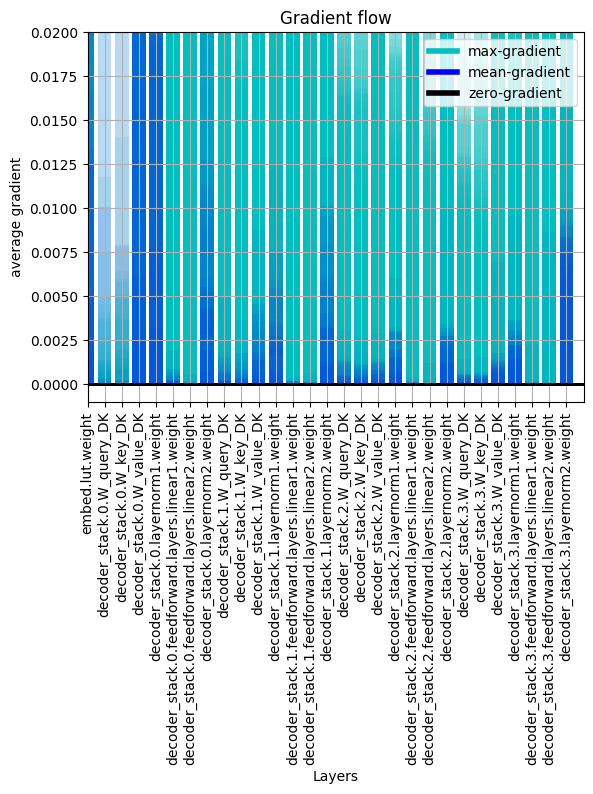

In [26]:
epochs = 100

losses = train_loop(
    train_dataloader=train_dataloader,
    model=model,
    loss_fn=loss,
    optimizer=adam_opt,
    scheduler=scheduler,
    device=device,
    epochs=epochs,
    train_dataset_len=len(train_dataset),
    sequence_length=max_sequence_length,
    val_dataloader=val_dataloader,
    test_dataset_len=len(val_dataset)
)

In [27]:
sample = val_dataset[10]
sample = create_training_sample(vocab_size=vocab_size, max_sequence_length=max_sequence_length)
test_op = model(sample.unsqueeze(0).to(device))
print(test_op)
print(sample.unsqueeze(0).flip(dims=(1,)))
print(test_op.argmax(-1))

tensor([[[-1.7978e+01, -2.7282e+00, -2.7495e+00, -2.6091e+00, -2.5947e+00,
          -2.6718e+00, -2.7431e+00, -2.4687e+00, -2.5616e+00, -2.5468e+00,
          -2.5948e+00, -2.7396e+00, -2.6641e+00, -2.6262e+00, -2.6962e+00,
          -1.7886e+01],
         [-1.8117e+01, -2.7053e+00, -2.6850e+00, -2.6786e+00, -2.5315e+00,
          -2.7066e+00, -2.7801e+00, -2.2966e+00, -2.5561e+00, -2.5793e+00,
          -2.6672e+00, -2.7587e+00, -2.7589e+00, -2.6624e+00, -2.6891e+00,
          -1.7989e+01],
         [-1.8130e+01, -2.7363e+00, -2.6663e+00, -2.4447e+00, -2.6128e+00,
          -2.5962e+00, -2.7530e+00, -2.6905e+00, -2.4841e+00, -2.6492e+00,
          -2.5516e+00, -2.7381e+00, -2.6942e+00, -2.6898e+00, -2.6996e+00,
          -1.7971e+01],
         [-1.8940e+01, -2.7687e+00, -2.5691e+00, -2.5088e+00, -2.5476e+00,
          -2.5647e+00, -2.7895e+00, -2.6631e+00, -2.6777e+00, -2.7289e+00,
          -2.5909e+00, -2.5384e+00, -2.6040e+00, -2.5952e+00, -2.8765e+00,
          -1.8513e+01],
    

Accuracy should be 50% ish since the model should only know the second half of the tokens.

In [28]:
test_dataset = [create_training_sample(vocab_size, max_sequence_length) for _ in range(int(dataset_size * 0.2))]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loop(test_dataloader, model, loss, device)

Test set samples: 63
Test error: Accuracy: 53.5, Avg loss: 0.005207823306322098



In [32]:
def inference(model, sample, device: torch.device):
    model.eval()
    print(f"Sample {sample}\n")
    input_BL = sample.to(device)
    result_BL = []
    model.eval()
    with torch.no_grad():
        total_tokens = sample.numel()
        print(f"Sample length {total_tokens}\n")

        
        seq_next_token_probabilities_BLV = model(input_BL)

        result_BL = seq_next_token_probabilities_BLV.argmax(dim=-1)

    print(result_BL == input_BL.flip(dims=(-1,)))
    print(result_BL)
    return result_BL

random_sample_L = create_training_sample(vocab_size=vocab_size, max_sequence_length=max_sequence_length)
# random_sample_L = train_dataset[1]
random_sample_BL = random_sample_L.unsqueeze(0)
# print(random_sample_BL.flip(dims=(1,)))
# print(random_sample[:2])
result = torch.tensor(inference(model, random_sample_BL, device))
        



Sample tensor([[12, 12,  5,  2,  5,  8,  3, 11]], dtype=torch.int32)

Sample length 8

tensor([[False, False,  True, False,  True,  True,  True,  True]],
       device='cuda:0')
tensor([[ 8,  8,  8,  7,  2,  5, 12, 12]], device='cuda:0')


/tmp/ipykernel_622517/77230133.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(inference(model, random_sample_BL, device))
